In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
def get_device():
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'

device = get_device()

# Data

In [3]:
x = torch.arange(0, 3000, 2).type(torch.float32).unsqueeze(dim=1).to(device)
y = ((x*4)+7).to(device)

print(x)
print(y)

tensor([[0.0000e+00],
        [2.0000e+00],
        [4.0000e+00],
        ...,
        [2.9940e+03],
        [2.9960e+03],
        [2.9980e+03]], device='mps:0')
tensor([[7.0000e+00],
        [1.5000e+01],
        [2.3000e+01],
        ...,
        [1.1983e+04],
        [1.1991e+04],
        [1.1999e+04]], device='mps:0')


In [4]:
train_split = int(len(x)*0.95)

x_train, y_train = x[:train_split], y[:train_split]
x_test, y_test = x[train_split:], y[train_split:]

# Model

In [5]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.W = nn.Parameter(
            torch.rand(size=(1,), dtype=torch.float32),
            requires_grad=True
        )
        self.B = nn.Parameter(
            torch.rand(size=(1,), dtype=torch.float32),
            requires_grad=True
        )

    def forward(self, x):
        return self.W*x + self.B

# Training

In [6]:
model = LinearModel().to(device)
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 30000

Other common losses:
- MAE: torch.nn.L1Loss()
- MSE: torch.nn.MSELoss()
- Binary Cross Entropy: torch.nn.BCELoss()

Other common optimizers:
- SGD: torch.optim.SGD(lr=0.001)

In [7]:
print(f"Model States before training: {model.state_dict()}")

Model States before training: OrderedDict([('W', tensor([0.3710], device='mps:0')), ('B', tensor([0.7553], device='mps:0'))])


In [8]:
epoch_count = []
loss_values = []
test_loss_values = []

for i in range(n_epochs):
    optimizer.zero_grad()

    model.train()
    
    out = model(x_train)
    loss = loss_fn(out, y_train)
    loss.backward()
    optimizer.step()

    if i % 1500 == 0:
        model.eval()
        epoch_count.append(i)
        with torch.inference_mode():
            test_pred = model(x_test)
            test_loss = loss_fn(test_pred, y_test)

        loss_values.append(loss.detach().item())
        test_loss_values.append(test_loss.detach().item())
        print(f"step: {i}/{n_epochs}: training loss={loss.item():.4f} | test_loss:{test_loss.item():.4f}")

step: 0/30000: training loss=5173.9775 | test_loss:10614.5918
step: 1500/30000: training loss=3036.4309 | test_loss:6226.9961
step: 3000/30000: training loss=899.0643 | test_loss:1839.7700
step: 4500/30000: training loss=0.9091 | test_loss:0.9898
step: 6000/30000: training loss=0.4661 | test_loss:0.5096
step: 7500/30000: training loss=0.5111 | test_loss:1.4231
step: 9000/30000: training loss=0.0819 | test_loss:0.1645
step: 10500/30000: training loss=0.0584 | test_loss:0.1924
step: 12000/30000: training loss=0.0278 | test_loss:0.0363
step: 13500/30000: training loss=0.0088 | test_loss:0.2928
step: 15000/30000: training loss=0.1056 | test_loss:0.0837
step: 16500/30000: training loss=0.1277 | test_loss:0.0418
step: 18000/30000: training loss=0.0115 | test_loss:0.0059
step: 19500/30000: training loss=0.0081 | test_loss:0.0000
step: 21000/30000: training loss=0.0699 | test_loss:0.1791
step: 22500/30000: training loss=0.1233 | test_loss:0.2433
step: 24000/30000: training loss=0.1406 | test_l

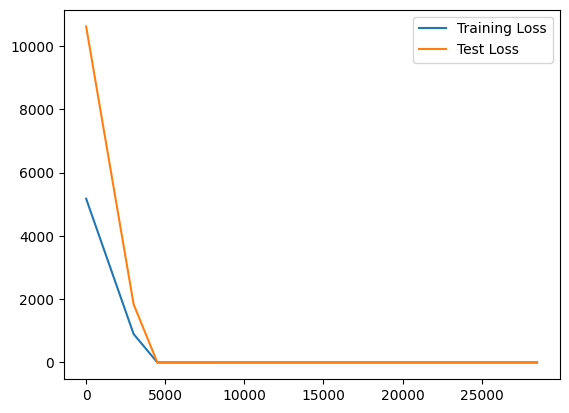

In [9]:
def plot_loss(epoch, loss, test_loss):
    plt.plot(epoch, loss, label='Training Loss')
    plt.plot(epoch, test_loss, label='Test Loss')
    plt.legend()

plot_loss(epoch_count, loss_values, test_loss_values)


In [10]:
print(f"Model States after training: {model.state_dict()}")

Model States after training: OrderedDict([('W', tensor([4.0000], device='mps:0')), ('B', tensor([7.0000], device='mps:0'))])


# Inference

You probably noticed we used `torch.inference_mode()` as a context manager to make the predictions.

As the name suggests, `torch.inference_mode()` is used when using a model for inference (making predictions).

`torch.inference_mode()` turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes (data going through the forward() method) faster.

In older PyTorch code, you may also see `torch.no_grad()` being used for inference. While `torch.inference_mode()` and `torch.no_grad()` do similar things, `torch.inference_mode()` is newer, potentially faster and preferred. 

In [11]:
model.eval()
with torch.inference_mode():
    pred = model(x_test)

# Plotting

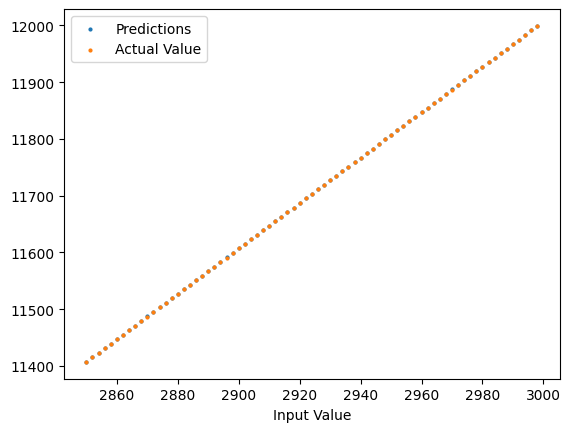

In [12]:
plt.scatter(x_test.cpu(), pred.detach().cpu(), s=4, label='Predictions')
plt.scatter(x_test.cpu(), y_test.cpu(), s=4, label='Actual Value')

plt.xlabel('Input Value')
plt.legend()

# Saving the model

In [13]:
# 1. Create models directory 
MODEL_PATH = Path("ml_models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "basic_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: ml_models/basic_model.pth


# Loading the model

In [14]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model = LinearModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH, weights_only=True))

<All keys matched successfully>

In [15]:
loaded_model.state_dict()

OrderedDict([('W', tensor([4.0000])), ('B', tensor([7.0000]))])